In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
columns = {0:'datetime',1:'open',2:'high',3:'low',4:'close',5:'volume'}

btc_raw = pd.read_csv("btcusd.csv", header=None)
eth_raw = pd.read_csv("ethusd60.csv", header=None)

In [3]:
def make_df(raw_df):
    df = raw_df.loc[:,:5]
    df.rename(columns=columns, inplace=True)
    df = df[["datetime", "close"]]
    
    df["timestamp"] = df["datetime"].apply(lambda x: dt.datetime.fromtimestamp(x))
    df = df.drop(columns="datetime")
    df.set_index("timestamp", inplace=True)
    df.index=pd.to_datetime(df.index)
    return df

In [4]:
btc = make_df(btc_raw)
eth = make_df(eth_raw)
btc.rename(columns={"close":"btc"}, inplace=True)
eth.rename(columns={"close":"eth"}, inplace=True)
hist_df = btc.merge(eth, how="inner", on="timestamp")
hist_df.index.dtype

dtype('<M8[ns]')

In [5]:
current_df = pd.read_csv("crypto_current.csv", parse_dates=True, infer_datetime_format=True, index_col="timestamp")
current_df.index.dtype

dtype('<M8[ns]')

In [6]:
num_ticks = 60
tickers = ["btc","eth"]
hist_shifted_df = pd.DataFrame()
for ticker in tickers:
    hist_shifted_df[ticker] = hist_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        hist_shifted_df[name] = hist_df[ticker].shift(i)
hist_shifted_df = hist_shifted_df.copy()
hist_shifted_df.shape

ipykernel_launcher:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(45978, 120)

In [7]:
hist_pct_returns_df_list = []
for ticker in tickers:
    name = f"{ticker}_Buy"
    returns_df = pd.DataFrame()
    returns_df[name] = hist_df[ticker].pct_change(periods=24).shift(-24).apply(lambda x : 1 if x >= 0.01 else 0)
    hist_pct_returns_df_list.append(returns_df)
hist_pct_returns_df_list[0]["btc_Buy"].sum()

16863

In [8]:
current_shifted_df = pd.DataFrame()
for ticker in tickers:
    current_shifted_df[ticker] = current_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        current_shifted_df[name] = current_df[ticker].shift(i)
current_shifted_df = current_shifted_df.copy()
current_shifted_df.dropna(inplace=True)

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [9]:
hist_pctchange_df = hist_shifted_df.pct_change()
hist_pctchange_df = pd.concat([hist_pctchange_df, *hist_pct_returns_df_list], axis=1)
hist_pctchange_df.dropna(inplace=True)
hist_pctchange_df.shape

(45918, 122)

In [10]:
current_pctchange_df = current_shifted_df.pct_change()
current_pctchange_df.dropna(inplace=True)

In [11]:
y_start = len(tickers)*num_ticks

In [12]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [13]:
X = hist_pctchange_df.iloc[:,0:y_start].values
y = []
for i in range(0,len(tickers)):
    y.append(hist_pctchange_df.iloc[:,y_start+i].values)

In [14]:
xgb_models = []
xgb_confusion = []
xgb_classification = []
target_names = ["Not Buy", "Buy"]
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = XGBClassifier(n_estimators=100, random_state=1, use_label_encoder=False, objective="binary:hinge", eval_metric="logloss")
    X_train, X_test, y_train, y_test = train_test_split(X, y[i],random_state=1,stratify=y[i])
    model.fit(X_train,y_train)
    xgb_models.append(model)
    predicted = model.predict(X_test)
    xgb_confusion.append(confusion_matrix(y_test, predicted))
    xgb_classification.append(classification_report(y_test, predicted, target_names=target_names))
    print("--------------------------------------")
    print(ticker)
    print(f"Training Data Score: {model.score(X_train, y_train)}")
    print(f"Testing Data Score: {model.score(X_test, y_test)}")
    print(xgb_confusion[i])
    print(xgb_classification[i])

--------------------------------------
btc
Training Data Score: 0.7413322492595389
Testing Data Score: 0.6324912891986063
[[6726  540]
 [3679  535]]
              precision    recall  f1-score   support

     Not Buy       0.65      0.93      0.76      7266
         Buy       0.50      0.13      0.20      4214

    accuracy                           0.63     11480
   macro avg       0.57      0.53      0.48     11480
weighted avg       0.59      0.63      0.56     11480

--------------------------------------
eth
Training Data Score: 0.7399094024043208
Testing Data Score: 0.5992160278745644
[[6074  759]
 [3842  805]]
              precision    recall  f1-score   support

     Not Buy       0.61      0.89      0.73      6833
         Buy       0.51      0.17      0.26      4647

    accuracy                           0.60     11480
   macro avg       0.56      0.53      0.49     11480
weighted avg       0.57      0.60      0.54     11480



In [15]:
#Predict pct-change for each of the tickers over the month of June 2021
y_current_predicted = []
current_returns_df_list = []
X = current_pctchange_df.values
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = xgb_models[i]
    predicted = model.predict(X)
    y_current_predicted.append(predicted)
    return_df = pd.DataFrame({"timestamp":current_pctchange_df.index, "buy_predicted": predicted})
    return_df = return_df.set_index("timestamp")
    return_df = return_df.merge(current_df[ticker], how="left", on="timestamp")
    print(ticker, return_df["buy_predicted"].sum())

    money = 10000
    num_shares = 0
    state = 0
    buy_index = 0
    money_list=[]

    for i in range(0,len(return_df)):
        if state == 1 and i == buy_index + 16:
            #sell
            price = return_df.iloc[i,1]
            money = num_shares * price
            state = 0
            print(f"sell {ticker}", i ,price)

        if return_df.iloc[i,0] == 1 and state == 0 and i < len(return_df) - 16:
            #buy
            price = return_df.iloc[i,1]
            num_shares = money / price
            buy_index = i
            state = 1
            print(f"buy {ticker}", i, price)

        if return_df.iloc[i,0] == 1 and state == 1 and i < len(return_df) - 16:
            buy_index = i

        if state == 0 :
            money_list.append(money)
        else:
            price = return_df.iloc[i,1]
            money_list.append(num_shares*price)
    
    return_df["ROI"] = money_list

    current_returns_df_list.append(return_df)

btc 106
buy btc 7 36840.5
sell btc 25 35743.7
buy btc 89 32932.5
sell btc 182 35533.3
buy btc 193 36010.0
sell btc 209 34979.9
buy btc 215 35934.3
sell btc 234 39584.0
buy btc 262 39920.2
sell btc 283 40116.0
buy btc 286 39775.9
sell btc 303 38867.4
buy btc 345 35683.1
sell btc 388 34573.6
buy btc 388 34573.6
sell btc 504 33080.2
buy btc 510 32059.9
sell btc 612 35900.0
buy btc 620 34602.4
sell btc 658 33565.6
eth 127
buy eth 9 2732.97
sell eth 27 2652.71
buy eth 27 2652.71
sell eth 138 2539.89
buy eth 150 2475.87
sell eth 172 2376.98
buy eth 174 2415.04
sell eth 190 2395.2
buy eth 190 2395.2
sell eth 227 2509.91
buy eth 248 2541.43
sell eth 282 2536.9
buy eth 290 2423.35
sell eth 322 2360.38
buy eth 336 2284.08
sell eth 567 1968.55
buy eth 586 2096.08
sell eth 655 2102.01


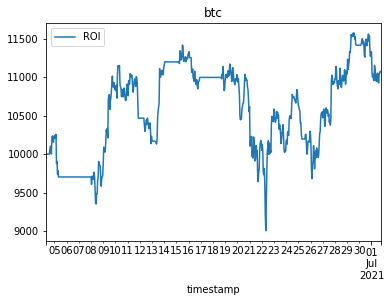

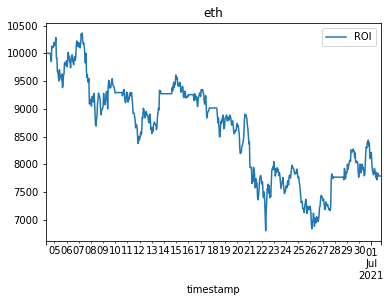

In [16]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    current_returns_df_list[i].plot(y="ROI", title=ticker)

In [17]:
starting_amount = 10000*len(tickers)
ending_amount = 0
for i in range(0,len(tickers)):
    ending_amount += current_returns_df_list[i].iloc[-1,-1]
ending_amount

18868.898875825715

In [18]:
print("TOTAL BUY SIGNALS------------")
for i in range(0,len(tickers)):
    print(f"{tickers[i]}: {current_returns_df_list[i]['buy_predicted'].sum()}")

TOTAL BUY SIGNALS------------
btc: 106
eth: 127


In [19]:
summary_df = current_returns_df_list[0].copy()
summary_df = pd.DataFrame(summary_df["ROI"])
summary_df = summary_df.rename(columns={"ROI": f"XGB_{tickers[0]}"})
for i in range(1,len(tickers)):
    temp_df = current_returns_df_list[i].copy()
    temp_df = pd.DataFrame(temp_df["ROI"])
    temp_df = temp_df.rename(columns={"ROI": f"XGB_{tickers[i]}"})
    summary_df = pd.concat([summary_df, temp_df], axis=1)
summary_df.to_csv("crypto_xgb_roi.csv")